# Loading Libraries

In [1]:
# Pandas, Numpy
import pandas as pd
import numpy as np 

# Tensorflow
import tensorflow as tf 

# RBM from Recommenders
from recommenders.models.rbm.rbm import RBM 
from recommenders.utils.timer import Timer 
from recommenders.utils.plot import line_graph 

# Affinity Matrix 
from recommenders.datasets.sparse import AffinityMatrix

# Evaluation 
from recommenders.evaluation.python_evaluation import (
    precision_at_k,
    recall_at_k
)
from sklearn.metrics import accuracy_score 

# Visualization
from matplotlib import pyplot as plt 

# Import & Read Dataset

In [2]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/online_retail_ratings_train.csv", index_col=0)
test = pd.read_csv("../../00_Data/online_retail_ratings_test.csv", index_col=0)

In [3]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (357692, 3)
Shape of Test: 	 (89479, 3)


In [4]:
# Check Number of Unique Items and User in Train & Test 
print("Unique Users in Train:", train.CustomerID.nunique())
print("Unique Users in Test:", test.CustomerID.nunique())
print("Unique Items in Train:", train.StockCode.nunique())
print("Unique Items in Test:", test.StockCode.nunique())

Unique Users in Train: 3696
Unique Users in Test: 3696
Unique Items in Train: 2769
Unique Items in Test: 2769


In [5]:
# Value Counts of Ratings in Train
train.purchased.value_counts()

 1    153304
-1    149998
 2     48666
-2      5724
Name: purchased, dtype: int64

In [6]:
# Value Counts of Ratings in Test
test.purchased.value_counts()

 1    38373
-1    37499
 2    12174
-2     1433
Name: purchased, dtype: int64

# Preparation of Datasets for Modeling 

In [7]:
# Set standard names for the analysis 
header = {
        "col_user": "CustomerID",
        "col_item": "StockCode",
        "col_rating": "purchased",
    }

# Instantiate the sparse matrix generation  
am_train = AffinityMatrix(df = train, col_user='CustomerID', col_item='StockCode', col_rating='purchased')
am_test = AffinityMatrix(df = test, col_user='CustomerID', col_item='StockCode', col_rating='purchased')

# Obtain the sparse matrix 
Xtr, _, _ = am_train.gen_affinity_matrix()
Xtst, _, _ = am_test.gen_affinity_matrix()

In [8]:
# Sanity Check: Print Shape of Train & Test Matrix - Do numbers match nr of unique users and items from above 
print(Xtr.shape)
print(Xtst.shape) 

(3696, 2769)
(3696, 2769)


In [9]:
# Sanity Check 2: Do the sum of values match number of instances in train and test set?
print(np.sum(Xtr))
print(np.sum(Xtst))

89190
22356


In [10]:
# Sanity check: Xtr & Xtst After reloading & Transformation
print(np.unique(Xtr))
print(np.unique(Xtst))

[-2 -1  0  1  2]
[-2 -1  0  1  2]


# Modeling

## Hyperparameter Tuning 1 

In [11]:
# Set up Parameters 
hidden_neurons = [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
batch = [200, 300]
lrate = [0.002, 0.003, 0.004]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
neurons = []
batches = []
learning_rates = []

# Loop through lists of parameters 

for n in hidden_neurons:
    for b in batch:
        for l in lrate:
            # Delete Model First
            try:
                del(model)
            except:
                pass
            
            # Define Model with Parameters
            model = RBM(
                possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])), # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=n,
                training_epoch=30,
                minibatch_size=b,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=l,
                seed=42
            )
            
            # Fit Model 
            model.fit(Xtr)
            
            # Recommend top k
            top_k = model.recommend_k_items(Xtst, top_k=20, remove_seen=True)
            
            # Map Back Xtst & Top K
            top_k_df = am_test.map_back_sparse(top_k, kind = 'prediction')
            test_df  = am_test.map_back_sparse(Xtst, kind='ratings')
            
            # Evaluation 
            recall_at_ten  = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
            recall_at_twenty = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
            precision_at_ten = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                            col_rating ='purchased', col_prediction="prediction",
                                            relevancy_method='top_k', k = 10)
            precision_at_twenty = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                col_rating ='purchased', col_prediction="prediction",
                                relevancy_method='top_k', k = 20)
            
            # Append lists 
            recall_10.append(recall_at_ten)
            recall_20.append(recall_at_twenty)
            precision_10.append(precision_at_ten)
            precision_20.append(precision_at_twenty)
            neurons.append(n)
            batches.append(b)
            learning_rates.append(l)
            
            # Print Results 
            print("Recall at 10 for ", n, "neurons:", recall_at_ten)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2023-05-23 11:39:12.281093: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 11:39:12.333825: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


Recall at 10 for  500 neurons: 0.017366945410954644
Recall at 10 for  500 neurons: 0.020208634948146977
Recall at 10 for  500 neurons: 0.021377402784833896
Recall at 10 for  500 neurons: 0.014954706059421124
Recall at 10 for  500 neurons: 0.0152970884647604
Recall at 10 for  500 neurons: 0.01697872508537805
Recall at 10 for  600 neurons: 0.024077822903453495
Recall at 10 for  600 neurons: 0.02673833347938126
Recall at 10 for  600 neurons: 0.0279105377233985
Recall at 10 for  600 neurons: 0.019644232402850837
Recall at 10 for  600 neurons: 0.02147821342320139
Recall at 10 for  600 neurons: 0.02370992678560568
Recall at 10 for  700 neurons: 0.03087777764542879
Recall at 10 for  700 neurons: 0.033844935904763375
Recall at 10 for  700 neurons: 0.03673703174040848
Recall at 10 for  700 neurons: 0.025462557952464975
Recall at 10 for  700 neurons: 0.02813885596536625
Recall at 10 for  700 neurons: 0.030102125796895807
Recall at 10 for  800 neurons: 0.029365563715797148
Recall at 10 for  800 n

In [12]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_1 = pd.DataFrame({
    "hidden_neurons": neurons,
    "minibatches": batches,
    "learning_rates":learning_rates,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_1.sort_values(by='recall@10', ascending=False)

,hidden_neurons,minibatches,learning_rates,recall@10,recall@20,precision@10,precision@20
56,1400,200,0.004,0.082096,0.111831,0.211228,0.147200
55,1400,200,0.003,0.079938,0.109031,0.206142,0.143926
62,1500,200,0.004,0.075741,0.106265,0.198350,0.142045
59,1400,300,0.004,0.072745,0.101330,0.188501,0.133550
54,1400,200,0.002,0.072325,0.101764,0.186742,0.133563
...,...,...,...,...,...,...,...
9,600,300,0.002,0.019644,0.032545,0.053030,0.043899
0,500,200,0.002,0.017367,0.028931,0.047430,0.039597
5,500,300,0.004,0.016979,0.028264,0.046077,0.038663
4,500,300,0.003,0.015297,0.025375,0.041964,0.035051


## Hyperparameter Tuning 2

In [32]:
# Set up Parameters 
hidden_neurons = [1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540]
batch = [200, 300]
lrate = [0.003, 0.004]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
neurons = []
batches = []
learning_rates = []

# Loop through lists of parameters 

for n in hidden_neurons:
    for b in batch:
        for l in lrate:
            # Delete Model First
            try:
                del(model)
            except:
                pass
            
            # Define Model with Parameters
            model = RBM(
                possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])), # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=n,
                training_epoch=30,
                minibatch_size=b,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=l,
                seed=42
            )
            
            # Fit Model 
            model.fit(Xtr)
            
            # Recommend top k
            top_k = model.recommend_k_items(Xtst, top_k=20, remove_seen=True)
            
            # Map Back Xtst & Top K
            top_k_df = am_test.map_back_sparse(top_k, kind = 'prediction')
            test_df  = am_test.map_back_sparse(Xtst, kind='ratings')
            
            # Evaluation 
            recall_at_ten  = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
            recall_at_twenty = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
            precision_at_ten = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                            col_rating ='purchased', col_prediction="prediction",
                                            relevancy_method='top_k', k = 10)
            precision_at_twenty = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                col_rating ='purchased', col_prediction="prediction",
                                relevancy_method='top_k', k = 20)
            
            # Append lists 
            recall_10.append(recall_at_ten)
            recall_20.append(recall_at_twenty)
            precision_10.append(precision_at_ten)
            precision_20.append(precision_at_twenty)
            neurons.append(n)
            batches.append(b)
            learning_rates.append(l)
            
            # Print Results 
            print("Recall at 10 for ", n, "neurons:", recall_at_ten)

Recall at 10 for  1350 neurons: 0.06669461044235533
Recall at 10 for  1350 neurons: 0.0706251121502506
Recall at 10 for  1350 neurons: 0.051635429384929876
Recall at 10 for  1350 neurons: 0.058320250515719964
Recall at 10 for  1360 neurons: 0.06687199998124399
Recall at 10 for  1360 neurons: 0.06932935734691438
Recall at 10 for  1360 neurons: 0.05658726618830555
Recall at 10 for  1360 neurons: 0.06163093605503641
Recall at 10 for  1370 neurons: 0.07243597458706316
Recall at 10 for  1370 neurons: 0.0773036013668901
Recall at 10 for  1370 neurons: 0.05871019394342438
Recall at 10 for  1370 neurons: 0.0652863665761506
Recall at 10 for  1380 neurons: 0.07945258760865323
Recall at 10 for  1380 neurons: 0.08302942007135518
Recall at 10 for  1380 neurons: 0.06557881237185251
Recall at 10 for  1380 neurons: 0.0730850921135241
Recall at 10 for  1390 neurons: 0.07877760665165721
Recall at 10 for  1390 neurons: 0.0786742698247191
Recall at 10 for  1390 neurons: 0.06350916014701256
Recall at 10 fo

In [33]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_2 = pd.DataFrame({
    "hidden_neurons": neurons,
    "minibatches": batches,
    "learning_rates":learning_rates,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_2.sort_values(by='recall@10', ascending=False)

,hidden_neurons,minibatches,learning_rates,recall@10,recall@20,precision@10,precision@20
41,1450,200,0.004,0.089702,0.122630,0.231304,0.162202
49,1470,200,0.004,0.087443,0.119317,0.227327,0.158306
33,1430,200,0.004,0.086589,0.118115,0.223485,0.155952
40,1450,200,0.003,0.086554,0.119399,0.222159,0.156872
32,1430,200,0.003,0.083337,0.115139,0.216531,0.152354
...,...,...,...,...,...,...,...
3,1350,300,0.004,0.058320,0.084070,0.154085,0.112649
78,1540,300,0.003,0.058194,0.084177,0.156710,0.115260
6,1360,300,0.003,0.056587,0.081532,0.149865,0.109740
62,1500,300,0.003,0.056258,0.082666,0.148782,0.111959


# Final Tuning Round

In [38]:
# Set up Parameters 
hidden_neurons = [1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459]
batch = [200, 300]
lrate = [0.003, 0.004]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
neurons = []
batches = []
learning_rates = []

# Loop through lists of parameters 

for n in hidden_neurons:
    for b in batch:
        for l in lrate:
            # Delete Model First
            try:
                del(model)
            except:
                pass
            
            # Define Model with Parameters
            model = RBM(
                possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])), # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=n,
                training_epoch=30,
                minibatch_size=b,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=l,
                seed=42
            )
            
            # Fit Model 
            model.fit(Xtr)
            
            # Recommend top k
            top_k = model.recommend_k_items(Xtst, top_k=20, remove_seen=True)
            
            # Map Back Xtst & Top K
            top_k_df = am_test.map_back_sparse(top_k, kind = 'prediction')
            test_df  = am_test.map_back_sparse(Xtst, kind='ratings')
            
            # Evaluation 
            recall_at_ten  = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
            recall_at_twenty = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
            precision_at_ten = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                            col_rating ='purchased', col_prediction="prediction",
                                            relevancy_method='top_k', k = 10)
            precision_at_twenty = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                col_rating ='purchased', col_prediction="prediction",
                                relevancy_method='top_k', k = 20)
            
            # Append lists 
            recall_10.append(recall_at_ten)
            recall_20.append(recall_at_twenty)
            precision_10.append(precision_at_ten)
            precision_20.append(precision_at_twenty)
            neurons.append(n)
            batches.append(b)
            learning_rates.append(l)
            
            # Print Results 
            print("Recall at 10 for ", n, "neurons:", recall_at_ten)

Recall at 10 for  1441 neurons: 0.0832286174394955
Recall at 10 for  1441 neurons: 0.08696107886843121
Recall at 10 for  1441 neurons: 0.06856337609605932
Recall at 10 for  1441 neurons: 0.07519837561022877
Recall at 10 for  1442 neurons: 0.07923871410438796
Recall at 10 for  1442 neurons: 0.08474520805786967
Recall at 10 for  1442 neurons: 0.06325618067537399
Recall at 10 for  1442 neurons: 0.07080277324116185
Recall at 10 for  1443 neurons: 0.08112320199730594
Recall at 10 for  1443 neurons: 0.08289731108892497
Recall at 10 for  1443 neurons: 0.06838152467766148
Recall at 10 for  1443 neurons: 0.0737285328515367
Recall at 10 for  1444 neurons: 0.08261259955558693
Recall at 10 for  1444 neurons: 0.08685599061326232
Recall at 10 for  1444 neurons: 0.067156777661063
Recall at 10 for  1444 neurons: 0.07225121111911724
Recall at 10 for  1445 neurons: 0.08631276620614688
Recall at 10 for  1445 neurons: 0.09009970466047036
Recall at 10 for  1445 neurons: 0.07365814766491051
Recall at 10 for

In [39]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_3 = pd.DataFrame({
    "hidden_neurons": neurons,
    "minibatches": batches,
    "learning_rates":learning_rates,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_3.sort_values(by='recall@10', ascending=False)

,hidden_neurons,minibatches,learning_rates,recall@10,recall@20,precision@10,precision@20
37,1450,200,0.004,0.091028,0.123801,0.233523,0.162906
69,1458,200,0.004,0.090726,0.122874,0.231602,0.160877
53,1454,200,0.004,0.090464,0.122337,0.233983,0.161621
45,1452,200,0.004,0.090113,0.122944,0.232035,0.161878
17,1445,200,0.004,0.090100,0.120472,0.231006,0.158617
...,...,...,...,...,...,...,...
26,1447,300,0.003,0.065446,0.095826,0.169832,0.126799
74,1459,300,0.003,0.064367,0.092910,0.168506,0.123674
6,1442,300,0.003,0.063256,0.091563,0.165070,0.122078
42,1451,300,0.003,0.061679,0.089656,0.161310,0.118994


In [50]:
df_tuning_3[df_tuning_3['hidden_neurons']==1450]

,hidden_neurons,minibatches,learning_rates,recall@10,recall@20,precision@10,precision@20
36,1450,200,0.003,0.086918,0.119974,0.222051,0.156575
37,1450,200,0.004,0.091028,0.123801,0.233523,0.162906
38,1450,300,0.003,0.069973,0.101359,0.181115,0.133482
39,1450,300,0.004,0.076569,0.109344,0.198052,0.143804


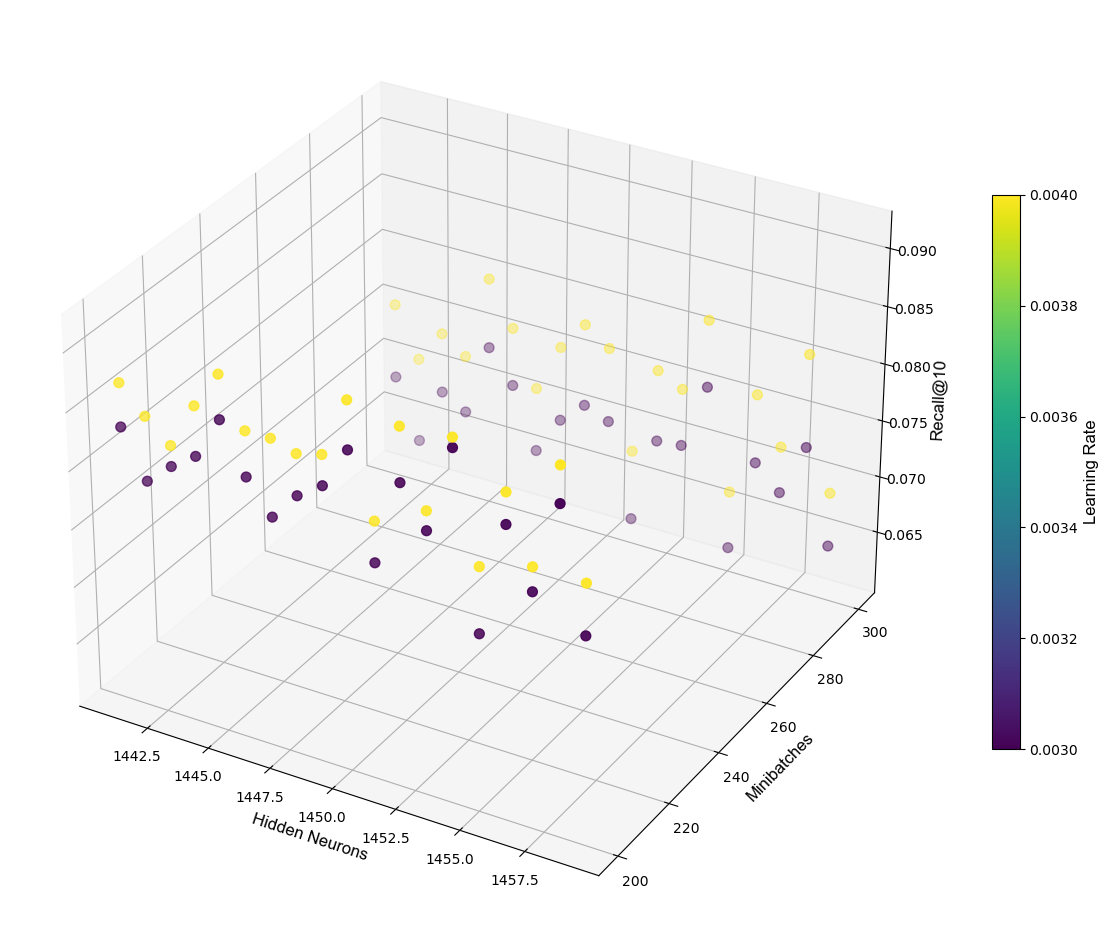

In [41]:
fig = plt.figure(figsize=(15,12))
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(projection='3d')

x, y, z = df_tuning_3.hidden_neurons, df_tuning_3['minibatches'], df_tuning_3['recall@10']
ax.set_xlabel('Hidden Neurons', fontname='Arial', fontsize=12)
ax.set_ylabel('Minibatches',fontname='Arial', fontsize=12)
ax.set_zlabel('Recall@10',fontname='Arial', fontsize=12)
scatter = ax.scatter(x,y,z, cmap='viridis', marker='o', s=50, c=df_tuning_3['learning_rates'])

# Colorbar
cbar = plt.colorbar(scatter, shrink=0.6)
cbar.set_label('Learning Rate', fontname='Arial', fontsize=12)
plt.show()


In [48]:
# Effects of Mini Batches
df_tuning_3.groupby("minibatches")['recall@10'].mean()

minibatches
200    0.084191
300    0.071407
Name: recall@10, dtype: float64

In [49]:
# Effects of Learning Rates
df_tuning_3.groupby("learning_rates")['recall@10'].mean()

learning_rates
0.003    0.075400
0.004    0.080197
Name: recall@10, dtype: float64

# Best Model: Accuracy on Test

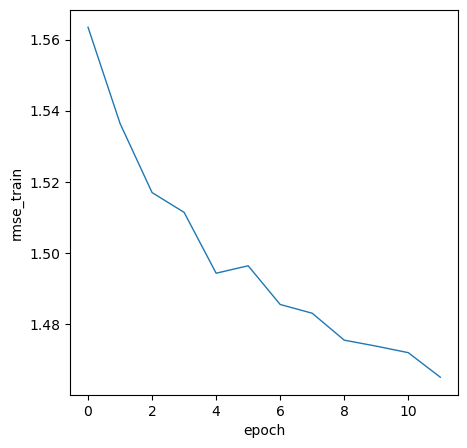

In [44]:
# Set up Model Object
best_model = RBM(possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])), # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=1450,
                training_epoch=11,
                minibatch_size=200,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=0.004,
                seed=42)
            
# Fit Model 
best_model.fit(Xtr)

# Line Graph
line_graph(values=best_model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')


In [45]:
# Make Predictions for entire Test Matrix
pred_test = best_model.predict(Xtst) ## Always Use Xtst for prediction - better results 

# Map Back Pred Test
pred_test = am_test.map_back_sparse(pred_test, kind = 'prediction')

# Merge test_pred with test
test_prediction_am = test_df.merge(pred_test, on=['StockCode', 'CustomerID'], how='left')

# Change Purchased above 0 to 1 and below zero to 0 
test_prediction_am['purchased'] = test_prediction_am['purchased'].apply(lambda x: 0 if x < 0 else 1 )

# Change prediction above 0 to 1 and below zero to 0 
test_prediction_am['prediction'] = test_prediction_am['prediction'].apply(lambda x: 0 if x < 0 else 1 )

# Accuracy 
accuracy_score(test_prediction_am.purchased, test_prediction_am.prediction)

0.9285083650912505